In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
from tensorflow import keras
from sklearn.metrics import confusion_matrix , classification_report

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=30

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "Mini_Figures",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 406 files belonging to 37 classes.


In [4]:
class_names = dataset.class_names
class_names

['AT-ST Raider from The Mandalorian',
 'Aunt May',
 'Black FIREFIGHTER',
 'Black Widow',
 'Burnt Anakin Skywalker',
 'Captain America Outriders Attack',
 'Captain America White Jumpsuit Helmet',
 'Darth Vader with Lightsaber',
 'Duel on Mustafar',
 'Emperor Palpatine Darth Sidious Sith Lord',
 'General Grievous White',
 'Han Solo',
 'Harry_Potter',
 'Harry_Potter_Ron Weasley',
 'Iron Man Hall of Armor',
 'Iron Man MK V',
 'Iron Man Mark 3 Armour',
 'Ironman Mark 41',
 'Jannah',
 'Jedi Master Mace Windu',
 'Klatooinian Raider with Helmet',
 'Klatooinian Raider with Neck Armor',
 'Luke Skywalker',
 'Mandalorian',
 'Mysterio',
 'Outrider Extended Arms Claws',
 'Owen Grady',
 'Pteranodon Chase',
 'R2-D2',
 'Spider-Gwen',
 'Spider_Man',
 'Stealth Suit Spider-man',
 'Supreme Leader Kylo Ren',
 'Taskmaster',
 'Venom',
 'Yelena Belova',
 'Yoda']

In [5]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[15 20  1 29 11  3 34 20 15 13 32  3  2 18 12 19  9 28 28 31 12  7 15 21
 21 10 30 24 35 15 33 32]


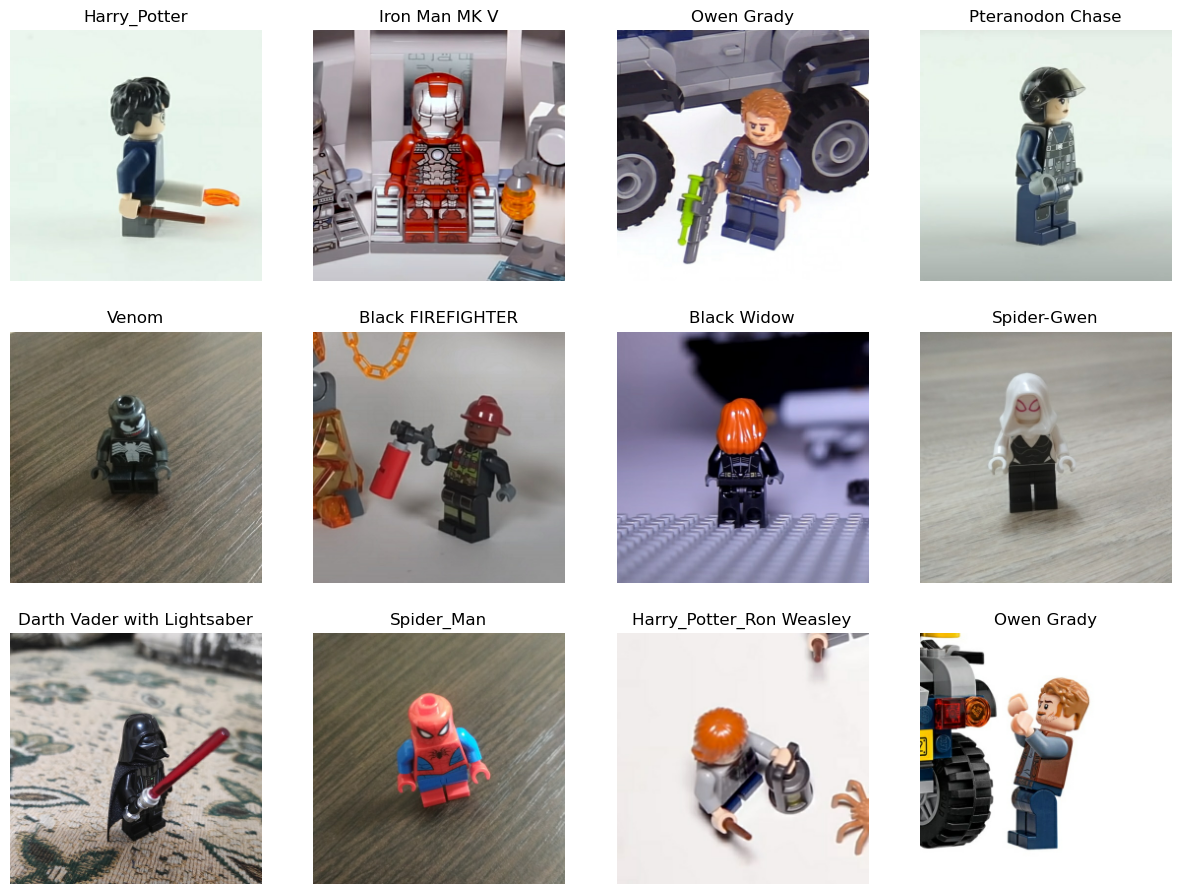

In [6]:
plt.figure(figsize=(15, 15))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [7]:
len(dataset)

13

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [12]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [13]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 37

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32,kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    #layers.Conv2D(64, (3, 3), activation='relu'),
    #layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [15]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (32, 246016)             

In [16]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [17]:
early_stopping = keras.callbacks.EarlyStopping(
  monitor="val_loss",
   patience=5,
   verbose=1
)
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=[early_stopping],
    verbose=1,
    epochs=50
)

Epoch 1/50


10/10 [==============================] - 4s 312ms/step - loss: 6.8917 - accuracy: 0.0258 - val_loss: 3.6088 - val_accuracy: 0.0000e+00
Epoch 2/50
10/10 [==============================] - 3s 295ms/step - loss: 3.6034 - accuracy: 0.0452 - val_loss: 3.5610 - val_accuracy: 0.0000e+00
Epoch 3/50
10/10 [==============================] - 3s 289ms/step - loss: 3.5326 - accuracy: 0.0484 - val_loss: 3.4444 - val_accuracy: 0.0938
Epoch 4/50
10/10 [==============================] - 3s 284ms/step - loss: 3.3716 - accuracy: 0.1097 - val_loss: 3.2872 - val_accuracy: 0.0625
Epoch 5/50
10/10 [==============================] - 3s 300ms/step - loss: 3.1806 - accuracy: 0.1548 - val_loss: 3.0415 - val_accuracy: 0.2500
Epoch 6/50
10/10 [==============================] - 3s 289ms/step - loss: 2.9936 - accuracy: 0.1774 - val_loss: 2.9052 - val_accuracy: 0.3125
Epoch 7/50
10/10 [==============================] - 3s 299ms/step - loss: 2.7671 - accuracy: 0.2742 - val_loss: 2.7083 - val_accuracy: 0.2

In [22]:
scores = model.evaluate(test_ds)

2/2 [==============================] - 0s 63ms/step - loss: 0.8294 - accuracy: 0.7344


In [23]:
from sklearn.metrics import confusion_matrix, accuracy_score

# 获取测试集上的预测结果
predictions = model.predict(test_ds)
y_true = []
y_pred = []

# 将测试集中的真实标签和预测结果收集起来
for images, labels in test_ds:
    y_true.extend(labels.numpy())
    y_pred.extend(tf.argmax(model.predict(images), axis=1).numpy())

# 计算混淆矩阵
conf_matrix = confusion_matrix(y_true, y_pred)
conf_matrix



# 计算各类别准确度
#class_accuracy = {}
#for i in range(37):
    #class_accuracy[class_names[i]] = conf_matrix[i][i] / sum(conf_matrix[i])

# 打印各类别准确度
#for class_name, accuracy in class_accuracy.items():
    #print(f'Class: {class_name}, Accuracy: {accuracy}')

# 计算总体准确度
#overall_accuracy = accuracy_score(y_true, y_pred)
#print(f'Overall Accuracy: {overall_accuracy}')



1/1 [==============================] - 0s 73ms/step


array([[1, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 2, 0, 0],
       [0, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 1]], dtype=int64)

In [26]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')
    

In [27]:
cm = confusion_matrix(class_label,_class_lable)
print_confusion_matrix(cm)

NameError: name 'class_label' is not defined

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

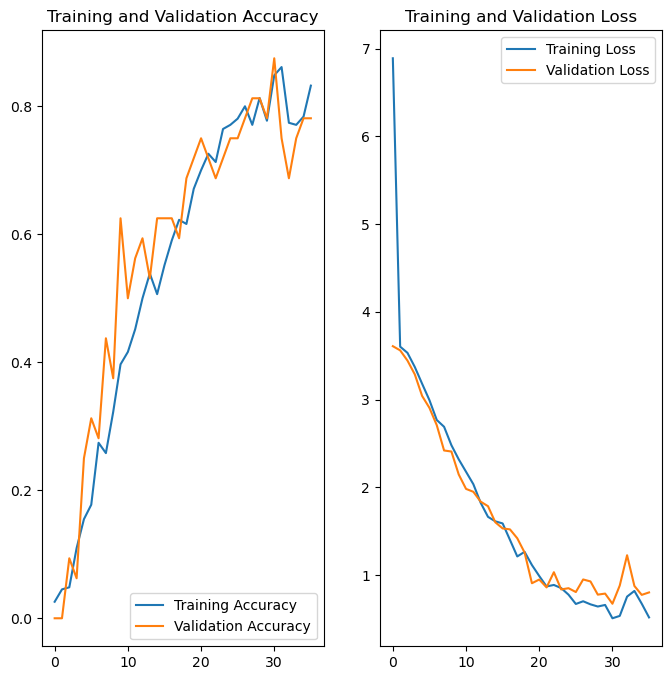

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(36), acc, label='Training Accuracy')
plt.plot(range(36), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(36), loss, label='Training Loss')
plt.plot(range(36), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: Iron Man MK V
1/1 [==============================] - 0s 72ms/step
predicted label: Iron Man MK V


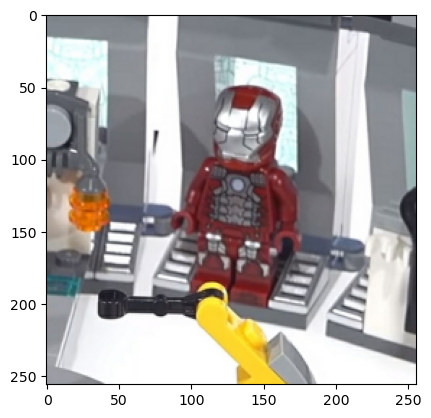

In [31]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [32]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 15ms/step


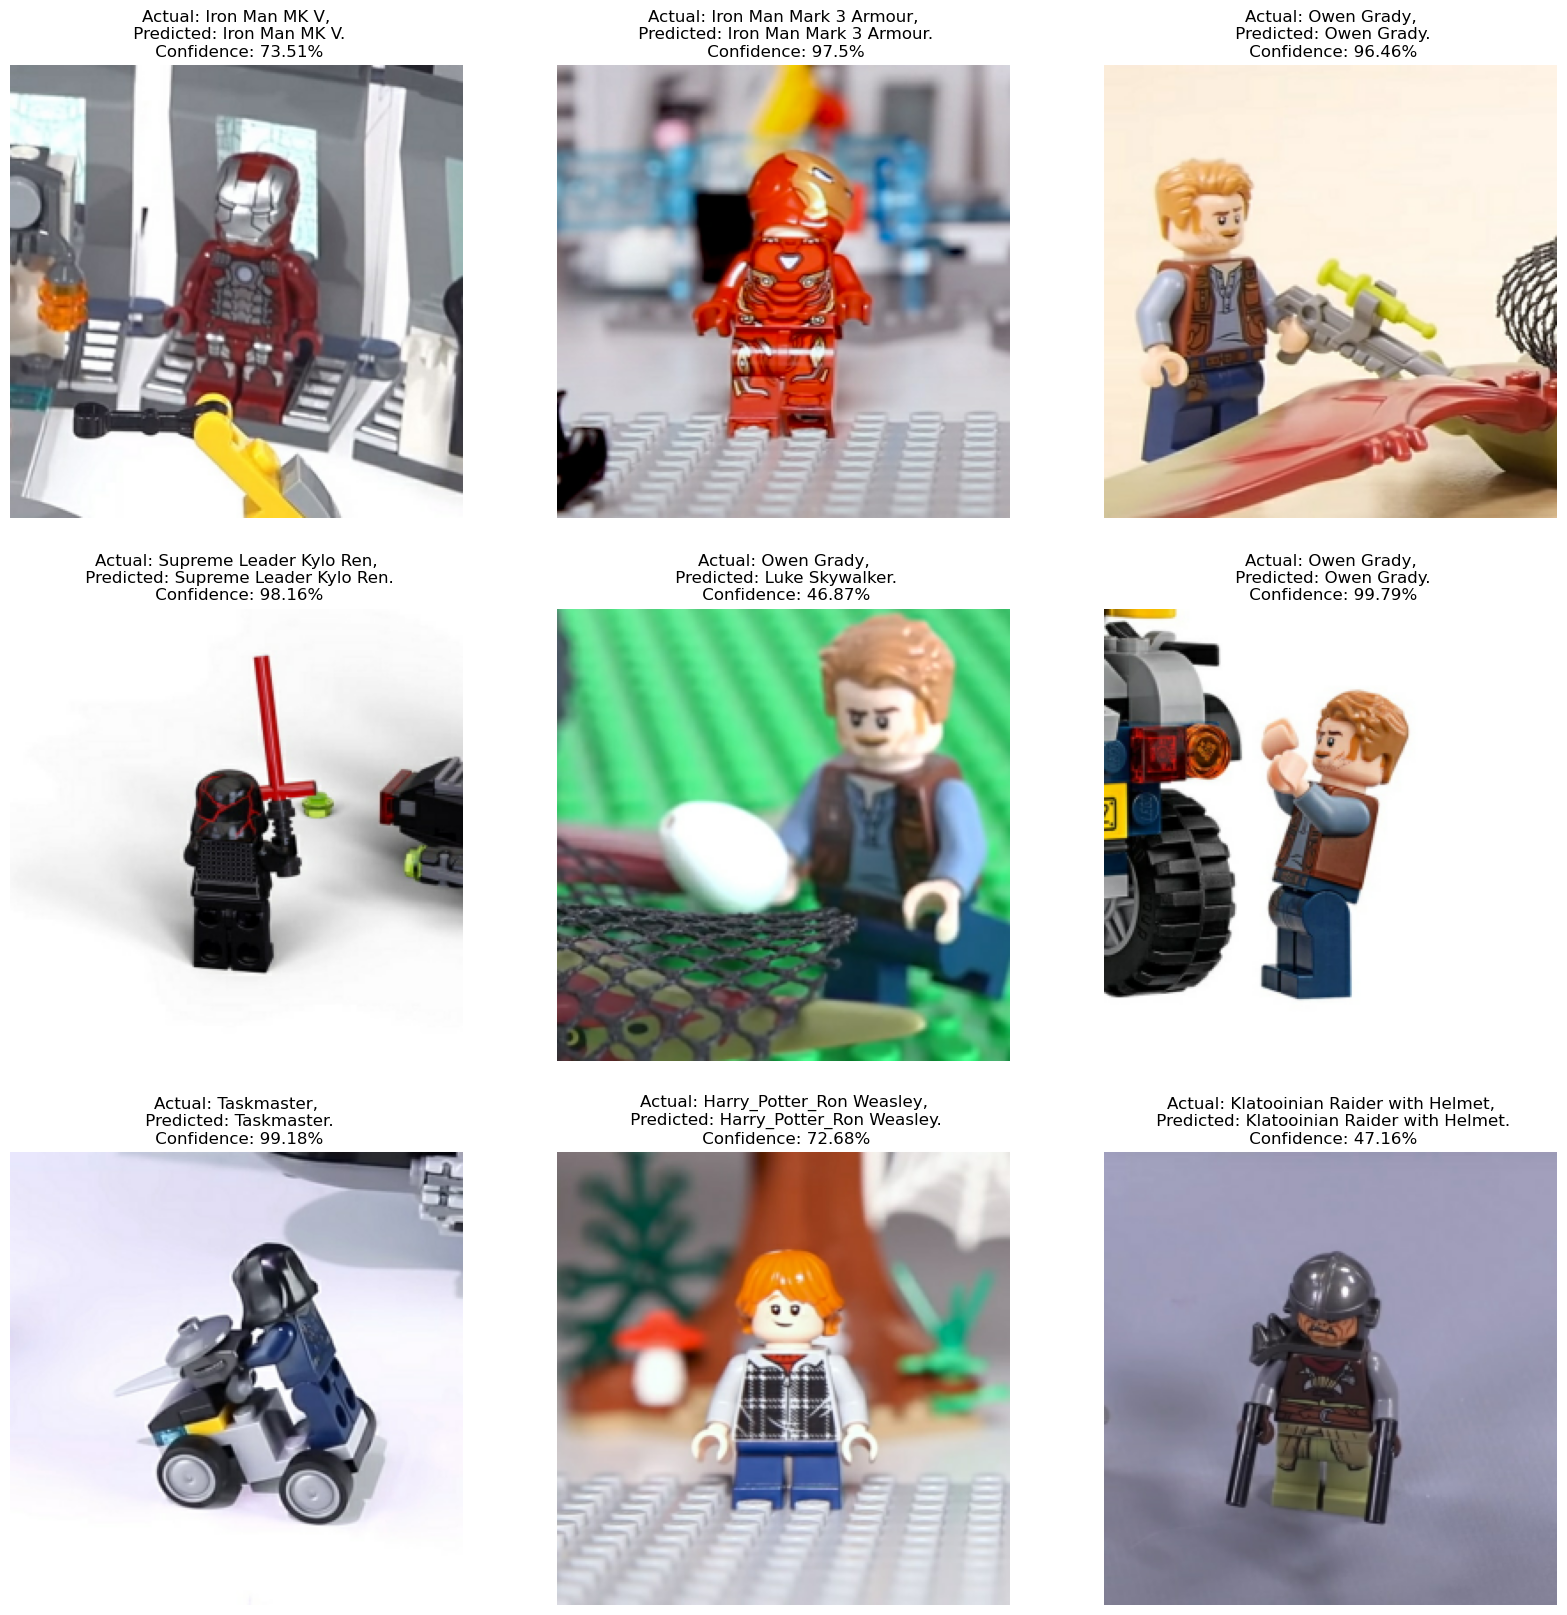

In [33]:
plt.figure(figsize=(20, 20))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [35]:
model_version="Mini_Figuers1"
model.save(f"./Models/{model_version}")

INFO:tensorflow:Assets written to: ./Models/Mini_Figuers1\assets


INFO:tensorflow:Assets written to: ./Models/Mini_Figuers1\assets
